In [691]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (25,10)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import category_encoders as ce
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import Ridge

TODO
- try Boruta feature selection  https://www.youtube.com/watch?v=hCwTDTdYirg
- https://www.youtube.com/watch?v=i-MF3CXWWEM&list=PLZoTAELRMXVPgjwJ8VyRoqmfNs2CJwhVH&index=4 mutual exclusion for regression
- https://www.youtube.com/watch?v=FndwYNcVe0U&list=PLZoTAELRMXVPgjwJ8VyRoqmfNs2CJwhVH&index=2 pearson

In [692]:
# load dataset
dataset = pd.read_csv('dataset/spotify_tracks.csv')
dataset.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


### **Preprocessing**

In [693]:
# dataset.isnull().sum() # to check if there are missing values

# drop records with missing values
dataset.dropna(inplace=True)

In [694]:
dataset.nunique(axis=0) # to check the number of distinct values for each column

Unnamed: 0          113999
track_id             89740
artists              31437
album_name           46589
track_name           73608
popularity             101
duration_ms          50696
explicit                 2
danceability          1174
energy                2083
key                     12
loudness             19480
mode                     2
speechiness           1489
acousticness          5061
instrumentalness      5346
liveness              1722
valence               1790
tempo                45652
time_signature           5
track_genre            114
dtype: int64

In [696]:
X = dataset.drop(columns=['Unnamed: 0', 'track_id', 'popularity'])  # features
y = dataset['popularity']                                           # target variable

#### Feature encoding

***explicit*** is a binary categorical feature that we map in {0,1}

In [698]:
X['explicit'] = X['explicit'].map({False : 0, True : 1})

***key*** and ***time_signature*** are categorical features with a restricted number of distinct values on which we apply one-hot encoding

In [699]:
ohe = ce.OneHotEncoder(cols=['key','time_signature']) 
X = ohe.fit_transform(X)

***artists***, ***album_name***, ***track_name*** and ***track_genre*** are categorical features with a large number of distinct values on which we apply binary encoding

In [700]:
be = ce.BinaryEncoder(cols=['artists', 'album_name', 'track_name', 'track_genre'])
X = be.fit_transform(X)

In [701]:
X.shape, X.columns

((113999, 84),
 Index(['artists_0', 'artists_1', 'artists_2', 'artists_3', 'artists_4',
        'artists_5', 'artists_6', 'artists_7', 'artists_8', 'artists_9',
        'artists_10', 'artists_11', 'artists_12', 'artists_13', 'artists_14',
        'album_name_0', 'album_name_1', 'album_name_2', 'album_name_3',
        'album_name_4', 'album_name_5', 'album_name_6', 'album_name_7',
        'album_name_8', 'album_name_9', 'album_name_10', 'album_name_11',
        'album_name_12', 'album_name_13', 'album_name_14', 'album_name_15',
        'track_name_0', 'track_name_1', 'track_name_2', 'track_name_3',
        'track_name_4', 'track_name_5', 'track_name_6', 'track_name_7',
        'track_name_8', 'track_name_9', 'track_name_10', 'track_name_11',
        'track_name_12', 'track_name_13', 'track_name_14', 'track_name_15',
        'track_name_16', 'duration_ms', 'explicit', 'danceability', 'energy',
        'key_1', 'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8',
        'key_9'

We split data in training and test set and we standardize them

In [702]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True) #stratify=y)

In [705]:
standard_scaler = preprocessing.StandardScaler().set_output(transform="pandas")

X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

# should I standardize also the target variable? boh, I don't think it's mandatory

'"\nstandard_scaler = preprocessing.StandardScaler().set_output(transform="pandas")\n\nX_train = standard_scaler.fit_transform(X_train)\nX_test = standard_scaler.transform(X_test)\n'

### **Ridge Regression implementation**

In [716]:
class RidgeRegression:

    def __init__(self, λ = 1.0):
        self.λ = λ
        self.w = None

    def fit(self, X, y):
        
        # insert dummy feature
        X = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
        
        I = np.identity(X.shape[1])
        I[0][0] = 0                         # justify this line

        self.w = np.linalg.inv(X.T @ X + self.λ * I) @ X.T @ y


    def predict(self, X):

        if self.w is None:
            raise RuntimeError('Model is still to fit')
        
        # insert dummy feature
        X = np.insert(X, 0, np.ones(X.shape[0]), axis=1) 

        return X @ self.w
    
    def get_params(self, deep=True):
        return {"λ": self.λ}

### **Ridge Regression test considering both numerical and categorical features**

In [ ]:
x = []
y = []

for λ in np.linspace(0.0, 200.0, num=40, endpoint=False):
    scores = cross_val_score(RidgeRegression(λ), 
                             X_train, 
                             y_train, 
                             scoring='neg_mean_squared_error', 
                             cv=5)
    x.append(λ)
    y.append(np.mean(scores))

best_λ = x[y.index(max(y))]
best_λ

KeyboardInterrupt: 

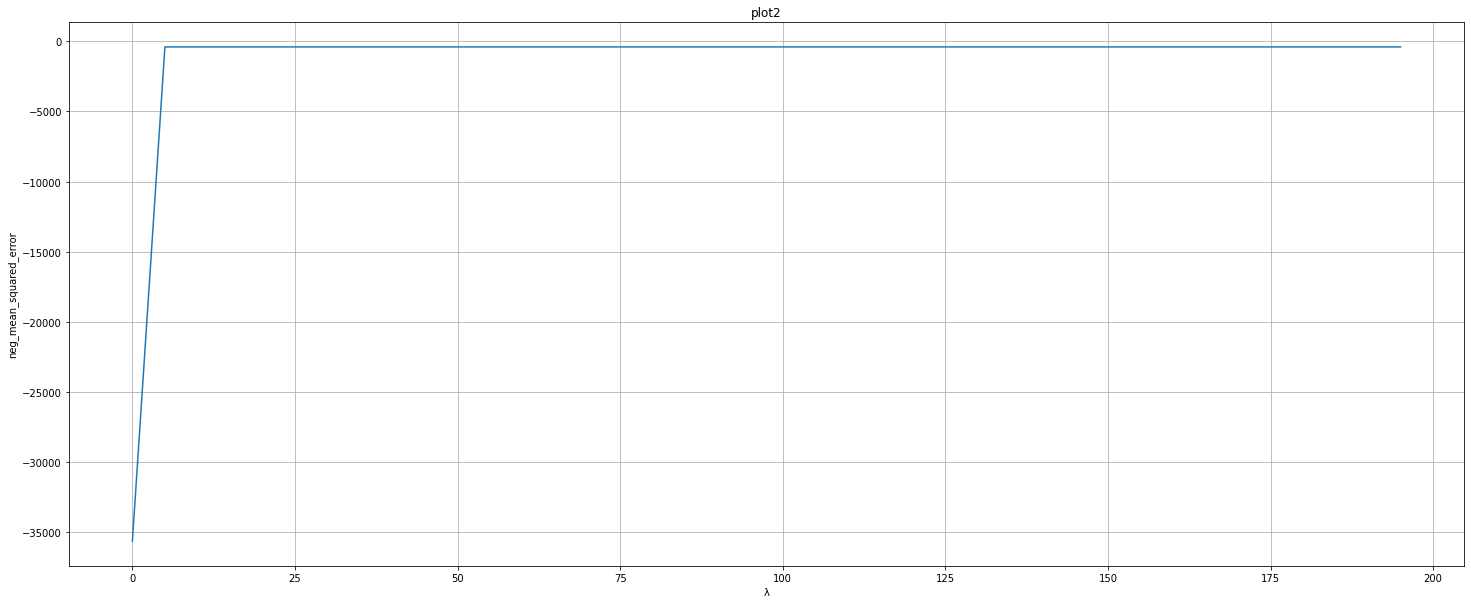

In [ ]:
fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='λ', ylabel='neg_mean_squared_error',
       title='plot2')
ax.grid()

plt.show()

In [ ]:
rr = RidgeRegression(best_λ)
rr.fit(X_train.values, y_train.values)
y_prediction = rr.predict(X_test.values)

mean_squared_error(y_prediction, y_test)

404.78430380122956

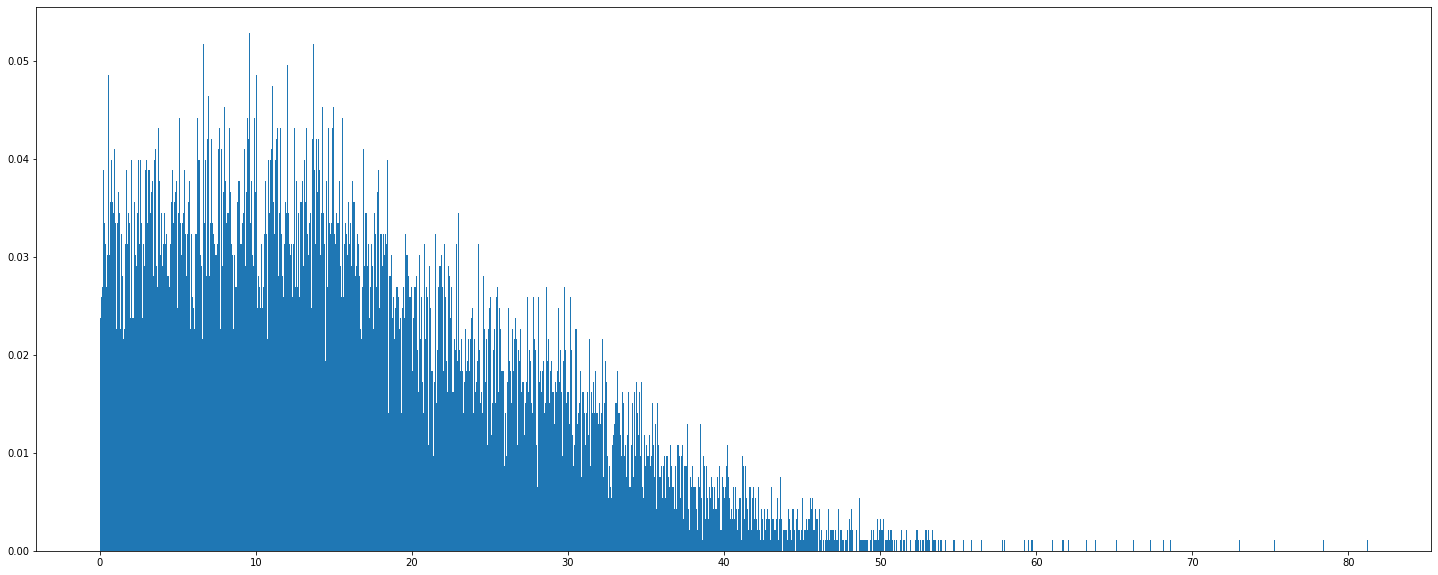

In [ ]:
fig, ax = plt.subplots()
ax.hist(np.abs(y_prediction - y_test), density=True, bins=2000)
plt.show()

Checking that my implementation performs exactly as the one in *sklearn*

In [ ]:
learner = GridSearchCV(estimator=Ridge(), 
                       param_grid={'alpha': np.linspace(0.0, 200.0, num=40, endpoint=False)}, 
                       cv=5, 
                       scoring='neg_mean_squared_error', 
                       return_train_score=True)
learner.fit(X_train, y_train)

learner.best_estimator_.fit(X_train, y_train)
y_prediction = learner.best_estimator_.predict(X_test)

print(learner.best_params_)
print(mean_squared_error(y_prediction, y_test))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.59139e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.09848e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


KeyboardInterrupt: 

### **Kernel Ridge Regression implementation**

In [ ]:
class KernelRidgeRegression:

    def __init__(self, α = 1.0, γ = 1.0):

        if α < 0: raise ValueError("α must be >= 0")
        if γ <= 0: raise ValueError("γ must be > 0")
        self._α = α
        self._γ = γ

        self._constant_term = None 
        self._x_i = None

    def gaussian_kernel(self, x_i, x_j):
        return np.exp(np.linalg.norm(x_i - x_j) / (-2 * self._γ))
    
    def fit(self, X, y):

        _X = X.copy()
        _X.insert(0, 'dummy_feature', 1)

        m = _X.shape[0]

        K = np.zeros((m, m))
        for i in range(m):
            for j in range(i, m):
                K[i][j] = self.gaussian_kernel(_X.iloc[i], _X.iloc[j])
                K[j][i] = K[i][j]
        
        I = np.identity(_X.shape[0])
        I[0][0] = 0                         # justify this line

        self._constant_term = y.T @ np.linalg.inv(K + self._α * I)
        self._x_i = _X
    
    def predict(self, X):

        if self._constant_term is None or self._x_i is None:
            raise RuntimeError('Model is still to fit')
        
        _X = X.copy()
        _X.insert(0, 'dummy_feature', 1)

        y_prediction = np.zeros(_X.shape[0])

        for i in range(len(y_prediction)):
            k_x = [self.gaussian_kernel(row, _X.iloc[i]) for _, row in self._x_i.iterrows()]
            y_prediction[i] = self._constant_term @ k_x

        return y_prediction
    
    
    def get_params(self, deep=True):
        return {"α": self._α, "γ": self._γ}
    """
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    """

In [ ]:
class KernelRidgeRegression2:

    def __init__(self, α = 1.0, γ = 1.0):

        if α < 0: raise ValueError("α must be >= 0")
        if γ <= 0: raise ValueError("γ must be > 0")
        self._α = α
        self._γ = γ

        self._constant_term = None 
        self._x_i = None

    def gaussian_kernel(self, x_i, x_j):
        return np.exp(np.linalg.norm(x_i - x_j) / (-2 * self._γ))
    
    def fit(self, X, y):

        #_X = X.copy()
        #_X.insert(0, 'dummy_feature', 1)

        m = X.shape[0]

        _X = np.insert(X, 0, np.ones(m), axis=1)

        print(_X)



        

        K = np.zeros((m, m))
        for i in range(m):
            for j in range(i, m):
                K[i][j] = self.gaussian_kernel(_X.iloc[i], _X.iloc[j])
                K[j][i] = K[i][j]
        
        I = np.identity(_X.shape[0])
        I[0][0] = 0                         # justify this line

        self._constant_term = y.T @ np.linalg.inv(K + self._α * I)
        self._x_i = _X
    
    def predict(self, X):

        if self._constant_term is None or self._x_i is None:
            raise RuntimeError('Model is still to fit')
        
        _X = X.copy()
        _X.insert(0, 'dummy_feature', 1)

        y_prediction = np.zeros(_X.shape[0])

        for i in range(len(y_prediction)):
            k_x = [self.gaussian_kernel(row, _X.iloc[i]) for _, row in self._x_i.iterrows()]
            y_prediction[i] = self._constant_term @ k_x

        return y_prediction
    
    
    def get_params(self, deep=True):
        return {"α": self._α, "γ": self._γ}
    """
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    """

In [ ]:
X_train_numerical_reduced = X_train_numerical.sample(n=300, random_state=1)
y_train_reduced = pd.Series( data = [y_train[i] for i, _ in X_train_numerical_reduced.iterrows()], 
                            index = [i for i, _ in X_train_numerical_reduced.iterrows()])

X_test_numerical_reduced = X_test_numerical.sample(n=100, random_state=1)
y_test_reduced = pd.Series( data = [y_test[i] for i, _ in X_test_numerical_reduced.iterrows()], 
                           index = [i for i, _ in X_test_numerical_reduced.iterrows()])

In [ ]:
rr = KernelRidgeRegression2()
rr.fit(X_train_numerical_reduced.values, y_train_reduced.values)

[[ 1.         -0.9073335   0.36399364 ... -0.67347962 -1.36606374
  -0.90285045]
 [ 1.         -0.41631037 -0.32836649 ...  0.76407055  1.7652549
   0.71275969]
 [ 1.          0.35530535 -0.41491151 ...  0.07677466 -0.200024
   0.32659434]
 ...
 [ 1.          0.38369039  0.88326375 ... -0.24326388  1.41389855
  -0.68930372]
 [ 1.         -0.89769906  1.92180395 ... -0.43213908  1.04709797
  -0.67189175]
 [ 1.         -0.47338585  1.1775168  ... -0.55805589 -0.75601646
  -0.53206234]]


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
y_prediction = rr.predict(pd.DataFrame(X_test_numerical_reduced))

In [ ]:
print(mean_squared_error(y_prediction, y_test_reduced))

In [ ]:
y_prediction - y_test_reduced